# Importing required python libraries

In [1]:
import torch
import torchvision
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Downloading MNIST dataset

In [2]:
batch_size_train = 64
batch_size_test = 1000

In [3]:
training_data = torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))
test_data=torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

100%|██████████| 9912422/9912422 [00:00<00:00, 91478731.41it/s]


Extracting /files/MNIST/raw/train-images-idx3-ubyte.gz to /files/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 113956438.22it/s]

Extracting /files/MNIST/raw/train-labels-idx1-ubyte.gz to /files/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 42778092.25it/s]


Extracting /files/MNIST/raw/t10k-images-idx3-ubyte.gz to /files/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 18640439.11it/s]


Extracting /files/MNIST/raw/t10k-labels-idx1-ubyte.gz to /files/MNIST/raw



In [36]:
train_loader = torch.utils.data.DataLoader(training_data
  ,
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(test_data
  ,
  batch_size=batch_size_test, shuffle=True)

# Data Visualisation


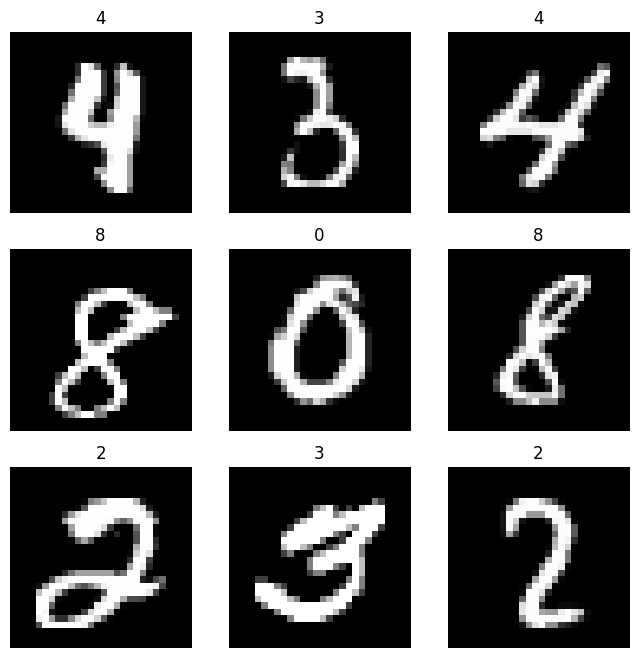

In [5]:
labels_map = {
    0: "0",
    1: "1",
    2: "2",
    3: "3",
    4: "4",
    5: "5",
    6: "6",
    7: "7",
    8: "8",
    9: "9",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [6]:
sample_idx = torch.randint(len(training_data), size=(1,)).item()
img, label = training_data[sample_idx]

In [7]:
img.shape

torch.Size([1, 28, 28])

# Defining Autoencoder Architecture

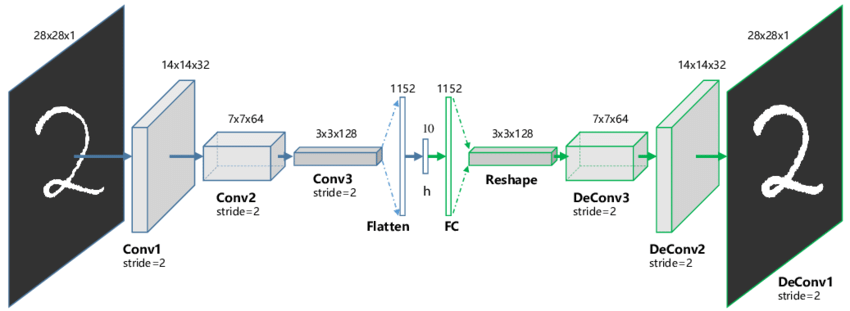

In [58]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        ## encoder layers ##

        self.conv1 = nn.Conv2d(1, 32, 2, stride=2) #[(W−K)/S]+1   ((28-2/2)+1)
        self.dropout = nn.Dropout(p=0.1)

        self.conv2 = nn.Conv2d(32, 64, 2, stride=2) #((14-2/2)+1)
        self.conv3 = nn.Conv2d(64, 128, 3, stride=2)#((7-3/2)+1)
        self.flatten = nn.Flatten()
        self.bottleneck=nn.Linear(3*3*128,10)
        self.decoderlinear=nn.Linear(10,3*3*128)
        ## decoder layers ##
        ## a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        self.t_conv1 = nn.ConvTranspose2d(128, 64, 3, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.t_conv3 = nn.ConvTranspose2d(32, 1, 2, stride=2)
    def forward(self, x):
        ## encode ##
        # add hidden layers with relu activation function
        x = F.relu(self.conv1(x))
        x = self.dropout(x)
        x = F.relu(self.conv2(x))
        x = self.dropout(x)
        x = F.relu(self.conv3(x))
        x = self.dropout(x)
        x = self.flatten(x)
        x1 = F.softmax(self.bottleneck(x))
        x = F.softmax(self.bottleneck(x))
        x = self.decoderlinear(x1)
        x = x.view(x.size(0), 128, 3, 3)

        ## decode ##
        # add transpose conv layers, with relu activation function
        x = self.t_conv1(x)
        x = self.dropout(x)
        x = self.t_conv2(x)
        x = self.dropout(x)
        # output layer (with sigmoid for scaling from 0 to 1)
        x = F.sigmoid(self.t_conv3(x))
        return x , x1
# initialize the NN
model = autoencoder()

In [59]:
print(model)

autoencoder(
  (conv1): Conv2d(1, 32, kernel_size=(2, 2), stride=(2, 2))
  (dropout): Dropout(p=0.1, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(2, 2), stride=(2, 2))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (bottleneck): Linear(in_features=1152, out_features=10, bias=True)
  (decoderlinear): Linear(in_features=10, out_features=1152, bias=True)
  (t_conv1): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2))
  (t_conv2): ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(2, 2))
  (t_conv3): ConvTranspose2d(32, 1, kernel_size=(2, 2), stride=(2, 2))
)


In [60]:
#Loss function
#criterion = nn.MSELoss()
distance   = nn.MSELoss()
class_loss = nn.CrossEntropyLoss()

#optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
#Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [61]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device

device = get_device()
print(device)
model.to(device)

cuda:0


autoencoder(
  (conv1): Conv2d(1, 32, kernel_size=(2, 2), stride=(2, 2))
  (dropout): Dropout(p=0.1, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(2, 2), stride=(2, 2))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (bottleneck): Linear(in_features=1152, out_features=10, bias=True)
  (decoderlinear): Linear(in_features=10, out_features=1152, bias=True)
  (t_conv1): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2))
  (t_conv2): ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(2, 2))
  (t_conv3): ConvTranspose2d(32, 1, kernel_size=(2, 2), stride=(2, 2))
)

In [62]:

num_epochs = 10
mse_multp = 0.5
cls_multp = 0.5

model.train()

for epoch in range(num_epochs):
     total_mseloss = 0.0
     total_clsloss = 0.0
     for ind, data in enumerate(train_loader ):
         img, labels = data[0].to(device), data[1].to(device)
         output, output_en = model(img)
         loss_mse = distance(output, img)
         loss_cls = class_loss(output_en, labels)
         loss = (mse_multp * loss_mse) + (cls_multp * loss_cls)  # Combine two losses together
         optimizer.zero_grad()
         loss.backward()
         optimizer.step()
         # Track this epoch's loss
         total_mseloss += loss_mse.item()
         total_clsloss += loss_cls.item()

     # Check accuracy on test set after each epoch:
     model.eval()   # Turn off dropout in evaluation mode
     acc = 0.0
     total_samples = 0
     for data in test_loader:
         # We only care about the 10 dimensional encoder output for classification
         img, labels = data[0].to(device), data[1].to(device)
         _, output_en = model(img)
         # output_en contains 10 values for each input, apply softmax to calculate class probabilities
         prob = output_en
         pred = torch.max(prob, dim=1)[1].detach().cpu().numpy() # Max prob assigned to class
         acc += (pred == labels.cpu().numpy()).sum()
         total_samples += labels.shape[0]
     model.train()   # Enables dropout back again
     print('epoch [{}/{}], loss_mse: {:.4f}  loss_cls: {:.4f}  Acc on test: {:.4f}'.format(epoch+1, num_epochs, total_mseloss / len(train_loader ), total_clsloss / len(train_loader ), acc / total_samples))

<ipython-input-58-a2bddc038e92>:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x1 = F.softmax(self.bottleneck(x))
<ipython-input-58-a2bddc038e92>:30: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.bottleneck(x))


epoch [1/10], loss_mse: 0.7217  loss_cls: 1.5706  Acc on test: 0.9591
epoch [2/10], loss_mse: 0.7083  loss_cls: 1.5019  Acc on test: 0.9647
epoch [3/10], loss_mse: 0.7083  loss_cls: 1.4962  Acc on test: 0.9726
epoch [4/10], loss_mse: 0.7082  loss_cls: 1.4931  Acc on test: 0.9764
epoch [5/10], loss_mse: 0.7082  loss_cls: 1.4893  Acc on test: 0.9774
epoch [6/10], loss_mse: 0.7081  loss_cls: 1.4860  Acc on test: 0.9773
epoch [7/10], loss_mse: 0.7080  loss_cls: 1.4854  Acc on test: 0.9791
epoch [8/10], loss_mse: 0.7080  loss_cls: 1.4827  Acc on test: 0.9814
epoch [9/10], loss_mse: 0.7079  loss_cls: 1.4826  Acc on test: 0.9808
epoch [10/10], loss_mse: 0.7079  loss_cls: 1.4815  Acc on test: 0.9805


<ipython-input-58-a2bddc038e92>:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x1 = F.softmax(self.bottleneck(x))
<ipython-input-58-a2bddc038e92>:30: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.bottleneck(x))


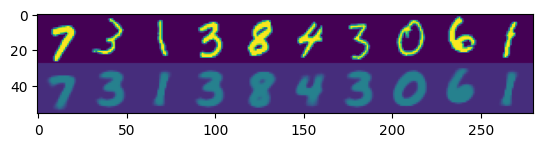

In [63]:
import numpy as np
import matplotlib.pyplot as plt

model.eval()
img, labels = list(train_loader)[0]
img = img.to(device)
output, output_en = model(img)
inp = img[0:10, 0, :, :].squeeze().detach().cpu()
out = output[0:10, 0, :, :].squeeze().detach().cpu()

# Just some trick to concatenate first ten images next to each other
inp = inp.permute(1,0,2).reshape(28, -1).numpy()
out = out.permute(1,0,2).reshape(28, -1).numpy()
combined = np.vstack([inp, out])

plt.imshow(combined)
plt.show()